# Libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
# for working with data
import pandas as pd
import numpy as np
from src.data_exploration import explore_functions as explr

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

# for preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import WoEEncoder
from imblearn.over_sampling import SMOTE

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# for evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

In [3]:
def check_balance(data, target, chart_types="pie", normalize=True, positive_target=0):
    target_counts = data[target].value_counts()
    target_counts.index = ["non-default" if i==positive_target else "default" for i in target_counts.index] 
    # sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index)
    if chart_types == "pie":
        plt.pie(target_counts.values, labels=target_counts.index, normalize=normalize, startangle=90,
            autopct="%1.1f%%", explode=[0, 0.1])
    elif chart_types == "bar":
        sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette="tab10")
        plt.xlabel("Targets")
    plt.title("Distribution of Targets")

def distribution_barplot(data, feature, normalize=True, title=None, legend="auto", labels=None):
    feature_count = data[feature].value_counts(normalize=normalize).reset_index()
    sns.barplot(x=feature_count[feature], y=feature_count.iloc[:, 1], hue=feature_count.iloc[:, 0],
                palette="Set2", legend=legend)      
    plt.xlabel(feature)
    plt.title(f"Distribution of {feature}")

def distitribution_otherbased(data, dist_feature, base_feature, normalize=False):
    dist = data.groupby(by=base_feature, as_index=False)[dist_feature].value_counts(normalize=normalize)
    sns.barplot(x=dist[base_feature], y=dist.iloc[:, -1], hue=dist[dist_feature])
    if normalize:
        plt.ylim(0, 1.05)

# Load Data

In [4]:
data_org = pd.read_csv("../data/taiwan_default_payments.csv")
data_org.head()

,default,id,limit_bal,gender,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,1,1,20000,female,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,1,2,120000,female,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,3,90000,female,university,single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,4,50000,female,university,married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,5,50000,male,university,married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


# Train Test Split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data_org.iloc[:, 1:], data_org.iloc[:, 0], test_size=0.2,
                                                    shuffle=True, random_state=42)
print(f"Training Set: {x_train.shape[0]} observations")
print(f"Testing Set: {x_test.shape[0]} observations")

Training Set: 24000 observations
Testing Set: 6000 observations


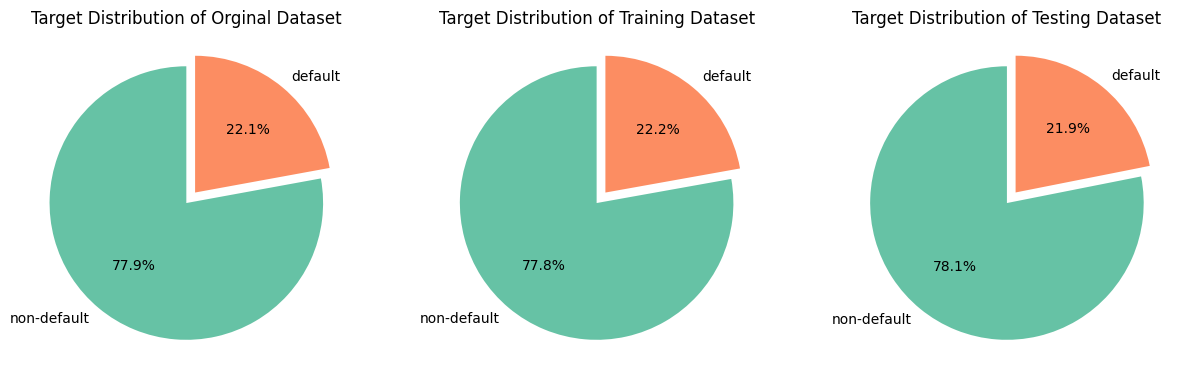

In [6]:
plt.figure(figsize=(15, 5))
dataset = [data_org, pd.DataFrame(y_train), pd.DataFrame(y_test)]
titles = ["Target Distribution of Orginal Dataset",
          "Target Distribution of Training Dataset",
          "Target Distribution of Testing Dataset"]
for i in range(3):
    plt.subplot(1, 3, i+1)
    check_balance(data=dataset[i], target="default")
    plt.title(titles[i])

# Preprocessing

In [7]:
class Preprocessing:
    def __init__(self, scaler=None, encoder=None, numeric_to_object=None,
                 numeric_into_bins=None, specific_encoders=None, balance=None):
        self.scaler = scaler
        self.encoder = encoder
        self.specific_encoders = specific_encoders
        self.num_to_obj = numeric_to_object
        self.numbins = numeric_into_bins
        self.cate_feas = None
        self.num_feas = None
        self.balance = balance
    
    def fit(self, X, y):
        data = X.copy()

        if self.num_to_obj is not None:
            data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        if self.numbins is not None:
            for feature, bins in self.numbins.items():
                if not isinstance(bins, dict):
                    self.numbins[feature] = self.create_bins(data[feature], bins=bins)
                data[feature] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])

        self.cate_feas = list(data.select_dtypes(include="object").columns)
        self.num_feas = [col for col in data.columns if col not in self.cate_feas]

        if self.specific_encoders is not None:
            self.cate_feas = [col for col in self.cate_feas if col not in self.specific_encoders.keys()]
            for feature, encoder in self.specific_encoders.items():
                if not isinstance(encoder, OneHotEncoder):
                    if isinstance(encoder, WoEEncoder):
                        self.specific_encoders[feature].fit(X=data[feature], y=y)
                    else:
                        self.specific_encoders[feature].fit(data[feature])
                else:
                    self.specific_encoders[feature].fit(data[[feature]])

        data[self.num_feas] = self.scaler.fit(data[self.num_feas])

        if isinstance(self.encoder, WoEEncoder):
            self.encoder.fit(X=data[self.cate_feas], y=y)
        else:
            self.encoder.fit(data[self.cate_feas])

    def fit_transform(self, X, y):
        self.fit(X, y)
        data = self.transform(X)
        if self.balance is not None:
            new_data, new_labels = self.balance.fit_resample(data, y)
            return new_data, new_labels
        return data

    def transform(self, X):
        data = X.copy()

        if self.num_to_obj is not None:
            data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        if self.numbins is not None:
            for feature in self.numbins.keys():
                data[feature] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])

        if self.specific_encoders is not None:
            for feature, encoder in self.specific_encoders.items():
                if isinstance(encoder, OneHotEncoder):
                    encoded = self.specific_encoders[feature].transform(data[[feature]])
                    encoded = pd.DataFrame(encoded, columns=self.specific_encoders[feature].get_feature_names_out(), index=data.index)
                    data = pd.concat([data, encoded], axis=1)
                    data = data.drop(feature, axis=1)
                else:
                    data[feature] = self.specific_encoders[feature].transform(data[feature])

        data[self.num_feas] = self.scaler.transform(data[self.num_feas])
        
        if isinstance(self.encoder, OneHotEncoder):
            encoded = self.encoder.transform(data[self.cate_feas])
            encoded = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(), index=data.index)
            data = pd.concat([data, encoded], axis=1)
            data = data.drop(self.cate_feas, axis=1)
        else:
            data[feature] = self.specific_encoders[feature].transform(data[feature])

        return data
    
    def create_bins(self, feature, bins):
        bins = pd.cut(feature, bins=bins, right=False, retbins=True)[1]
        bins_dict = {}
        for i in range(len(bins)-1):
            if i==0:
                bins_name = f"under {bins[i]}"
                lower = bins[i]-10**10
                upper = bins[i+1]
            elif i==len(bins)-2:
                bins_name = f"over {bins[i]}"
                lower = bins[i]
                upper = bins[i+1]
            else:
                bins_name = f"{bins[i]} - {bins[i+1]}"
                lower = bins[i]
                upper = bins[i+1] + 10**10
            bins_dict[(lower, upper)] = bins_name
        return bins_dict
            
    def convert_into_bins(self, X, feature, bins):
        data = X.copy()
        for bins, bins_name in bins.items():
            data.loc[data[feature].between(bins[0], bins[1], "right"), f"{feature}_bins"] = bins_name
        return data.iloc[:, -1]

In [13]:
class DefaultPaymentClassifier:
    def __init__(self, processor, model, balance=None):
        self.processor = processor
        self.model = model
        self.balance = balance
    
    def fit(self, X, y):
        processed_x = self.processor.fit_transform(X, y)
        if self.balance is not None:
            processed_x, y = self.balance.fit_resample(processed_x, y)
            processed_x = pd.DataFrame(processed_x, columns=self.balance.get_feature_names_out())
        self.model.fit(processed_x, y)

    def predict(self, X):
        processed_x = self.processor.transform(X)
        predited = self.model.predict(processed_x)
        return predited
    
    def predict_proba(self, X):
        processed_x = self.processor.transform(X)
        predicted_proba = self.model.predict_proba(processed_x)
        return predicted_proba

In [9]:
def evaluation(y_true, y_pred, y_pred_prob, scoring=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    scores = {'accuracy': accuracy_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'roc_auc': roc_auc_score}
    
    result = {}
    for method in scoring:
        if method == 'roc_auc':
            result[method] = scores[method](y_true, y_pred_prob.T[1])
        else:
            result[method] = scores[method](y_true, y_pred)

    return result

def cross_validation(X, y, estimator, cv=5, random_state=42, methods=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = {method: [] for method in methods}
    for train_index, test_index in skf.split(X, y):
        x_train, y_train = X.iloc[train_index], y.iloc[train_index]
        x_test, y_test = X.iloc[test_index], y.iloc[test_index]

        estimator.fit(x_train, y_train)
        y_pred = estimator.predict(x_test)
        y_pred_proba = estimator.predict_proba(x_test)

        score = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_proba)
        for method in scores.keys():
            scores[method].append(score[method])

    avg_scores = {key: np.mean(values) for key, values in scores.items()}
    return avg_scores

# Phase 1 - Logistic Regression + Different Preprocessing Techniques

In this phase, we will use Logistic Regression as a baseline model and try some different preprocessing methods to find the best one.

### Different Ways to Dealing with Numerical Features
Logistic Regression + WoE + StandardScaler

In [10]:
try:
    output_df = pd.read_csv("../output/csv/phase_1/all_results.csv")
except:
    output = {"categorical_features": [],
                "encoder": [],
                "scaler": [],
                "smote": [],
                "roc_auc": [],
                "accuracy": [],
                "f1": [],
                "precision": [],
                "recall": []}

    testcases = {"cate": [["gender", "marriage", "education"],
                            ["gender", "marriage", "education", "age"],
                            ["gender", "marriage", "education", "pay_x"],
                            ["gender", "marriage", "education", "age", "pay_x"],
                            ["gender", "marriage", "education", "age", "pay_x", "bill_amt", "pay_amt"]],
                    "encoder": {"OrdinalEncoder": OrdinalEncoder(),
                            "OneHotEncoder": OneHotEncoder(),
                            "WoE": WoEEncoder(fill_value=0.00001)},
                    "scaler": {"MinMaxScaler": MinMaxScaler(),
                        "StandardScaler": StandardScaler()},
                    "smote": {0: None, 1: SMOTE()}}

    model = LogisticRegression(max_iter=1000)

    for cate_cols in testcases['cate']:
        numbins = {}
        if 'age' in cate_cols:
            numbins["age"] = {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40", (40, 50): "40-50",
                                (50, 60): "50-60", (60, 100): "over 60"}
        if "pay_x" in cate_cols:
            num_to_cate = [f"pay_{i}" for i in range(1, 7, 1)]
        else:
            num_to_cate = None
        if ("bill_amt" in cate_cols) and ("pay_amt" in cate_cols):
            billbins = {f"bill_amt{i}": 10 for i in range(1, 7, 1)}
            paybins = {f"pay_amt{i}": 10 for i in range(1, 7, 1)}
            numbins.update(billbins)
            numbins.update(paybins)
        if len(numbins) == 0:
            numbins = None
        for scaler_name, scaler in testcases["scaler"].items():
            for encoder_name, encoder in testcases["encoder"].items():
                for smote_used, smote in testcases['smote'].items():
                    processor = Preprocessing(scaler=scaler,
                                            encoder=encoder,
                                            numeric_into_bins=numbins,
                                            numeric_to_object=num_to_cate,
                                            specific_encoders={"gender": LabelEncoder()})
                    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=smote)
                    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
                    output["categorical_features"].append(", ".join(cate_cols))
                    output["encoder"].append(encoder_name)
                    output["scaler"].append(scaler_name)
                    output["smote"].append(smote_used)
                    for method, score in scores.items():
                        output[method].append(score)
    output_df = pd.DataFrame(output)
    output_df
    # output_df.to_csv("../output/csv/phase_1/all_results.csv", index=False)

In [14]:
output_df[output_df['smote']==0].to_csv("../output/csv/phase_1/nosmote_results.csv", index=False)

In [17]:
output_df.loc[(output_df['smote']==0) & (output_df['scaler']=="StandardScaler")]

,categorical_features,encoder,scaler,smote,roc_auc,accuracy,f1,precision,recall
6,"gender, marriage, education",OrdinalEncoder,StandardScaler,0,0.723055,0.810219,0.361009,0.712747,0.241734
8,"gender, marriage, education",OneHotEncoder,StandardScaler,0,0.724855,0.810719,0.364030,0.714301,0.244270
10,"gender, marriage, education",WoE,StandardScaler,0,0.723778,0.810490,0.362588,0.713643,0.243049
18,"gender, marriage, education, age",OrdinalEncoder,StandardScaler,0,0.723156,0.810187,0.361195,0.712160,0.241969
20,"gender, marriage, education, age",OneHotEncoder,StandardScaler,0,0.725032,0.810531,0.363267,0.713224,0.243707
22,"gender, marriage, education, age",WoE,StandardScaler,0,0.723773,0.810396,0.362662,0.712547,0.243237
30,"gender, marriage, education, pay_x",OrdinalEncoder,StandardScaler,0,0.724738,0.809969,0.369549,0.699371,0.251127
32,"gender, marriage, education, pay_x",OneHotEncoder,StandardScaler,0,0.772801,0.822167,0.474060,0.688935,0.361357
34,"gender, marriage, education, pay_x",WoE,StandardScaler,0,0.768635,0.820604,0.472297,0.679388,0.361967
42,"gender, marriage, education, age, pay_x",OrdinalEncoder,StandardScaler,0,0.724882,0.809948,0.369613,0.699090,0.251221


In [15]:
output_df.loc[(output_df['smote']==0) & (output_df['scaler']=="StandardScaler") & (output_df['encoder']=="WoE")]

,categorical_features,encoder,scaler,smote,roc_auc,accuracy,f1,precision,recall
10,"gender, marriage, education",WoE,StandardScaler,0,0.723778,0.810490,0.362588,0.713643,0.243049
22,"gender, marriage, education, age",WoE,StandardScaler,0,0.723773,0.810396,0.362662,0.712547,0.243237
34,"gender, marriage, education, pay_x",WoE,StandardScaler,0,0.768635,0.820604,0.472297,0.679388,0.361967
46,"gender, marriage, education, age, pay_x",WoE,StandardScaler,0,0.768708,0.820688,0.472574,0.679709,0.362202
58,"gender, marriage, education, age, pay_x, bill_amt, pay_amt",WoE,StandardScaler,0,0.765980,0.819896,0.468321,0.678202,0.357646


In [18]:
output_df.loc[(output_df['smote']==1) & (output_df['scaler']=="StandardScaler") & (output_df['encoder']=="WoE")]

,categorical_features,encoder,scaler,smote,roc_auc,accuracy,f1,precision,recall
11,"gender, marriage, education",WoE,StandardScaler,1,0.722244,0.679667,0.471454,0.371854,0.644045
23,"gender, marriage, education, age",WoE,StandardScaler,1,0.723434,0.676396,0.470936,0.369443,0.649352
35,"gender, marriage, education, pay_x",WoE,StandardScaler,1,0.767472,0.781604,0.533674,0.506890,0.563451
47,"gender, marriage, education, age, pay_x",WoE,StandardScaler,1,0.767746,0.781896,0.533942,0.507489,0.563310
59,"gender, marriage, education, age, pay_x, bill_amt, pay_amt",WoE,StandardScaler,1,0.765967,0.777833,0.533519,0.499263,0.572845


In [23]:
output_df.loc[(output_df['smote']==1) & (output_df['scaler']!="fMinMaxScaler")
              & (output_df['categorical_features']=="gender, marriage, education, age, pay_x")]

,categorical_features,encoder,scaler,smote,roc_auc,accuracy,f1,precision,recall
37,"gender, marriage, education, age, pay_x",OrdinalEncoder,MinMaxScaler,1,0.722027,0.700875,0.480442,0.390765,0.623568
39,"gender, marriage, education, age, pay_x",OneHotEncoder,MinMaxScaler,1,0.760436,0.805708,0.523299,0.574067,0.480838
41,"gender, marriage, education, age, pay_x",WoE,MinMaxScaler,1,0.766013,0.782812,0.535409,0.509380,0.564250
43,"gender, marriage, education, age, pay_x",OrdinalEncoder,StandardScaler,1,0.721045,0.692948,0.473798,0.382193,0.623239
45,"gender, marriage, education, age, pay_x",OneHotEncoder,StandardScaler,1,0.762763,0.809531,0.513851,0.592200,0.453880
47,"gender, marriage, education, age, pay_x",WoE,StandardScaler,1,0.767746,0.781896,0.533942,0.507489,0.563310


In [10]:
output = {"model": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

models = {"KNN": KNeighborsClassifier(),
          "RandomForest": RandomForestClassifier(),
          "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
          "Catboost": CatBoostClassifier(verbose=False, random_state=42),
          "XGBoost": XGBClassifier(random_state=42)}
processor = Preprocessing(scaler=MinMaxScaler(),
                         encoder=OneHotEncoder(),
                         numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                         numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
for model_name, model in models.items():
    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
    output["model"].append(model_name)
    for method, score in scores.items():
        output[method].append(score)

In [14]:
output_df = pd.DataFrame(output)
output_df

,model,roc_auc,accuracy,f1,precision,recall
0,KNN,0.918139,0.818698,0.675448,0.560108,0.850648
1,RandomForest,0.999792,0.997729,0.994886,0.993956,0.995820
2,LightGBM,0.847869,0.830802,0.582177,0.643641,0.531562
3,Catboost,0.886316,0.854729,0.625970,0.729680,0.548141
4,XGBoost,0.931834,0.885729,0.727494,0.772125,0.687770


In [13]:
# output_df.to_csv("../output/csv/phase_2/result_validation.csv", index=False)

In [16]:
def modelling_evaluation(estimator, x_train, y_train, x_test, y_test, scoring=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    y_pred_proba = estimator.predict_proba(x_test)
    scores = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_proba)
    return scores

In [17]:
# processor = Preprocessing(scaler=MinMaxScaler(),
#                          encoder=OneHotEncoder(sparse_output=False),
#                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
#                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
#                                                     "30-40", (40, 50): "40-50", (50, 60): "50-60",
#                                                     (60, 100): "over 60"}},
#                          specific_encoders={"gender": LabelEncoder()})

# model = KNeighborsClassifier()
# estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
# # processor.fit_transform(x_train.iloc[:, 1:], y_train)
# # processor.transform(x_test.iloc[:, 1:])
# modelling_evaluation(estimator=estimator, x_train=x_train.iloc[:, 1:], y_train=y_train,
#                      x_test=x_test.iloc[:, 1:], y_test=y_test)

{'roc_auc': 0.6795932617174012,
 'accuracy': 0.6726666666666666,
 'f1': 0.43367935409457903,
 'precision': 0.34895591647331786,
 'recall': 0.5727341964965728}

In [18]:
output = {"model": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

models = {"KNN": KNeighborsClassifier(),
          "RandomForest": RandomForestClassifier(),
          "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
          "Catboost": CatBoostClassifier(verbose=False, random_state=42),
          "XGBoost": XGBClassifier(random_state=42)}
processor = Preprocessing(scaler=MinMaxScaler(),
                          encoder=OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                     (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
for model_name, model in models.items():
    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
    scores = modelling_evaluation(estimator=estimator, x_train=x_train.iloc[:, 1:], y_train=y_train,
                                  x_test=x_test.iloc[:, 1:], y_test=y_test)
    output["model"].append(model_name)
    for method, score in scores.items():
        output[method].append(score)

In [19]:
output_df = pd.DataFrame(output)
output_df

,model,roc_auc,accuracy,f1,precision,recall
0,KNN,0.676656,0.669000,0.434832,0.347115,0.581874
1,RandomForest,0.739721,0.790000,0.486553,0.523225,0.454684
2,LightGBM,0.768888,0.812333,0.504837,0.597294,0.437167
3,Catboost,0.767057,0.815500,0.491502,0.619213,0.407464
4,XGBoost,0.749439,0.796667,0.497115,0.541779,0.459254


In [ ]:
processor = Preprocessing(scaler=MinMaxScaler(),
                         encoder=OneHotEncoder(),
                         numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                         numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
model = RandomForestClassifier()
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)

In [15]:
processor = Preprocessing(scaler=MinMaxScaler(),
                          encoder=OneHotEncoder(),
                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
model = RandomForestClassifier()
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)

In [16]:
scores

{'roc_auc': 0.9997964701194906,
 'accuracy': 0.9977604166666667,
 'f1': 0.9949551770300481,
 'precision': 0.9942335143490922,
 'recall': 0.9956791525166334}

In [ ]:
processor = Preprocessing(scaler=MinMaxScaler(),
                          encoder=OneHotEncoder(),
                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
model = RandomForestClassifier()
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())